In [1]:
import os 
os.environ["JAX_PLATFORMS"] = "cpu"
import numpy as np 
import matplotlib.pyplot as plt 
import h5py 
from tqdm import tqdm
from getdist import MCSamples, plots
import matplotlib as mpl
import jax
jax.config.update("jax_enable_x64", True)
from jax import jacfwd, jacrev
from jax.lib import xla_bridge
jax.config.update("jax_xla_backend", "cpu")
import jax.numpy as jnp

In [2]:
# #load normalizing flow model
# from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
# # Model parameters
# n_feature = 82
# n_layers = 12
# n_hidden=3
# n_hiddens = [64]*n_hidden
# n_bins = 10
# key, subkey = jax.random.split(jax.random.PRNGKey(5))

# params_array = np.load("/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/notebooks/params_array_from_lhc_new.npy")
# data = jnp.array(params_array)[:10000]

# model = MaskedCouplingRQSpline(
#     data.shape[1],
#     n_layers,
#     n_hiddens,
#     n_bins,
#     subkey,
#     data_cov=None,
#     data_mean=None,
# )
# model = model.load_model("/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/nf_models/nf_model")

# prior_samples = model.sample(subkey, 10000, sigma_factor=1.)

In [3]:
# # lets get some prior samples from the gaussian copula 
# import pickle 
# from scipy.interpolate import interp1d
# from scipy.stats import norm
# def generate_new_samples(empirical_cdfs, mean_gaussian, cov_gaussian, num_new_samples, rng_key):
#     L = jnp.linalg.cholesky(cov_gaussian*gc_factor)
#     z = jax.random.normal(rng_key, (num_new_samples, mean_gaussian.shape[0]))
#     gaussian_samples = mean_gaussian + z @ L.T
#     gaussian_samples = np.nan_to_num(gaussian_samples, nan=0.0, posinf=5.0, neginf=-5.0)
#     uniform_samples = norm.cdf(gaussian_samples)
#     epsilon = 1e-6
#     uniform_samples = np.clip(uniform_samples, epsilon, 1 - epsilon)
#     generated_samples = np.zeros_like(uniform_samples)
#     for i in range(uniform_samples.shape[1]):
#         data_points = empirical_cdfs[i].x
#         cdf_values = empirical_cdfs[i].y
#         # Create inverse CDF function
#         inverse_cdf = interp1d(
#             cdf_values,
#             data_points,
#             bounds_error=False,
#             fill_value=(data_points[0], data_points[-1])
#         )
#         generated_samples[:, i] = inverse_cdf(uniform_samples[:, i])
        
#     return generated_samples

# with open('empirical_gc_cdf_data.pkl', 'rb') as f:
#     empirical_cdf_data = pickle.load(f)
# # Reconstruct empirical CDF functions
# empirical_cdfs = []

# for cdf_data in empirical_cdf_data:
#     cdf_func = interp1d(
#         cdf_data['x'],
#         cdf_data['y'],
#         bounds_error=False,
#         fill_value=(0.0, 1.0)
#     )
#     empirical_cdfs.append(cdf_func)

# loaded_params = np.load('gaussian_copula_params.npz')
# mean_gaussian = loaded_params['mean_gaussian']
# cov_gaussian = loaded_params['cov_gaussian']


# rng_key = jax.random.PRNGKey(int(1))
# num_samps = 10000
# gc_factor=1
# prior_samples = generate_new_samples(empirical_cdfs, mean_gaussian, cov_gaussian, num_samps, rng_key)
cov_file="/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/knots_data/covariance_80_knots_new.npy"
mu_file="/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/knots_data/mu_80_knots_new.npy"

cov = np.load(cov_file)
mean = np.load(mu_file)

import jax
import jax.numpy as jnp
import numpy as np

# Load mean and covariance
cov_file = "/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/knots_data/covariance_80_knots_new.npy"
mu_file = "/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/knots_data/mu_80_knots_new.npy"

cov = np.load(cov_file)
mean = np.load(mu_file)

# Convert to JAX arrays
cov_jax = jnp.array(cov)
mean_jax = jnp.array(mean)

def generate_new_samples(rng_key, num_samples, sigma_factor=1.0):
    """
    Generate samples from a multivariate Gaussian distribution with the given mean and scaled covariance matrix.

    Parameters:
    - rng_key: JAX random key.
    - num_samples: Number of samples to generate.
    - sigma_factor: Scaling factor for the covariance matrix.

    Returns:
    - samples: Generated samples as a JAX array of shape (num_samples, D), where D is the dimensionality.
    """
    # Scale the covariance matrix
    scaled_cov = sigma_factor * cov_jax

    # Regularize the covariance matrix to ensure positive definiteness
    epsilon = 1e-6 * jnp.eye(cov_jax.shape[0])
    scaled_cov += epsilon

    # Perform Cholesky decomposition
    L = jnp.linalg.cholesky(scaled_cov)

    D = mean_jax.shape[0]

    # Generate standard normal samples
    z = jax.random.normal(rng_key, shape=(num_samples, D))

    # Generate samples from multivariate normal distribution
    samples = mean_jax + z @ L.T

    return samples

rng_key = jax.random.PRNGKey(0)
num_samples = 10000
prior_samples = generate_new_samples(rng_key, num_samples)
    

In [4]:
n_parameters=82
param_names = [f'param_{i+1}' for i in range(n_parameters)]
labels = [f'Parameter {i+1}' for i in range(n_parameters)]

num_params_to_plot = 10
param_names_to_plot = param_names[:num_params_to_plot]
labels_to_plot = labels[:num_params_to_plot]
prior_mc_samples = MCSamples(samples=prior_samples[:, :num_params_to_plot], names=param_names_to_plot, labels=labels_to_plot)

Removed no burn in


In [5]:
emu_inputs = np.load("/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/notebooks/params_array_from_lhc_new.npy")

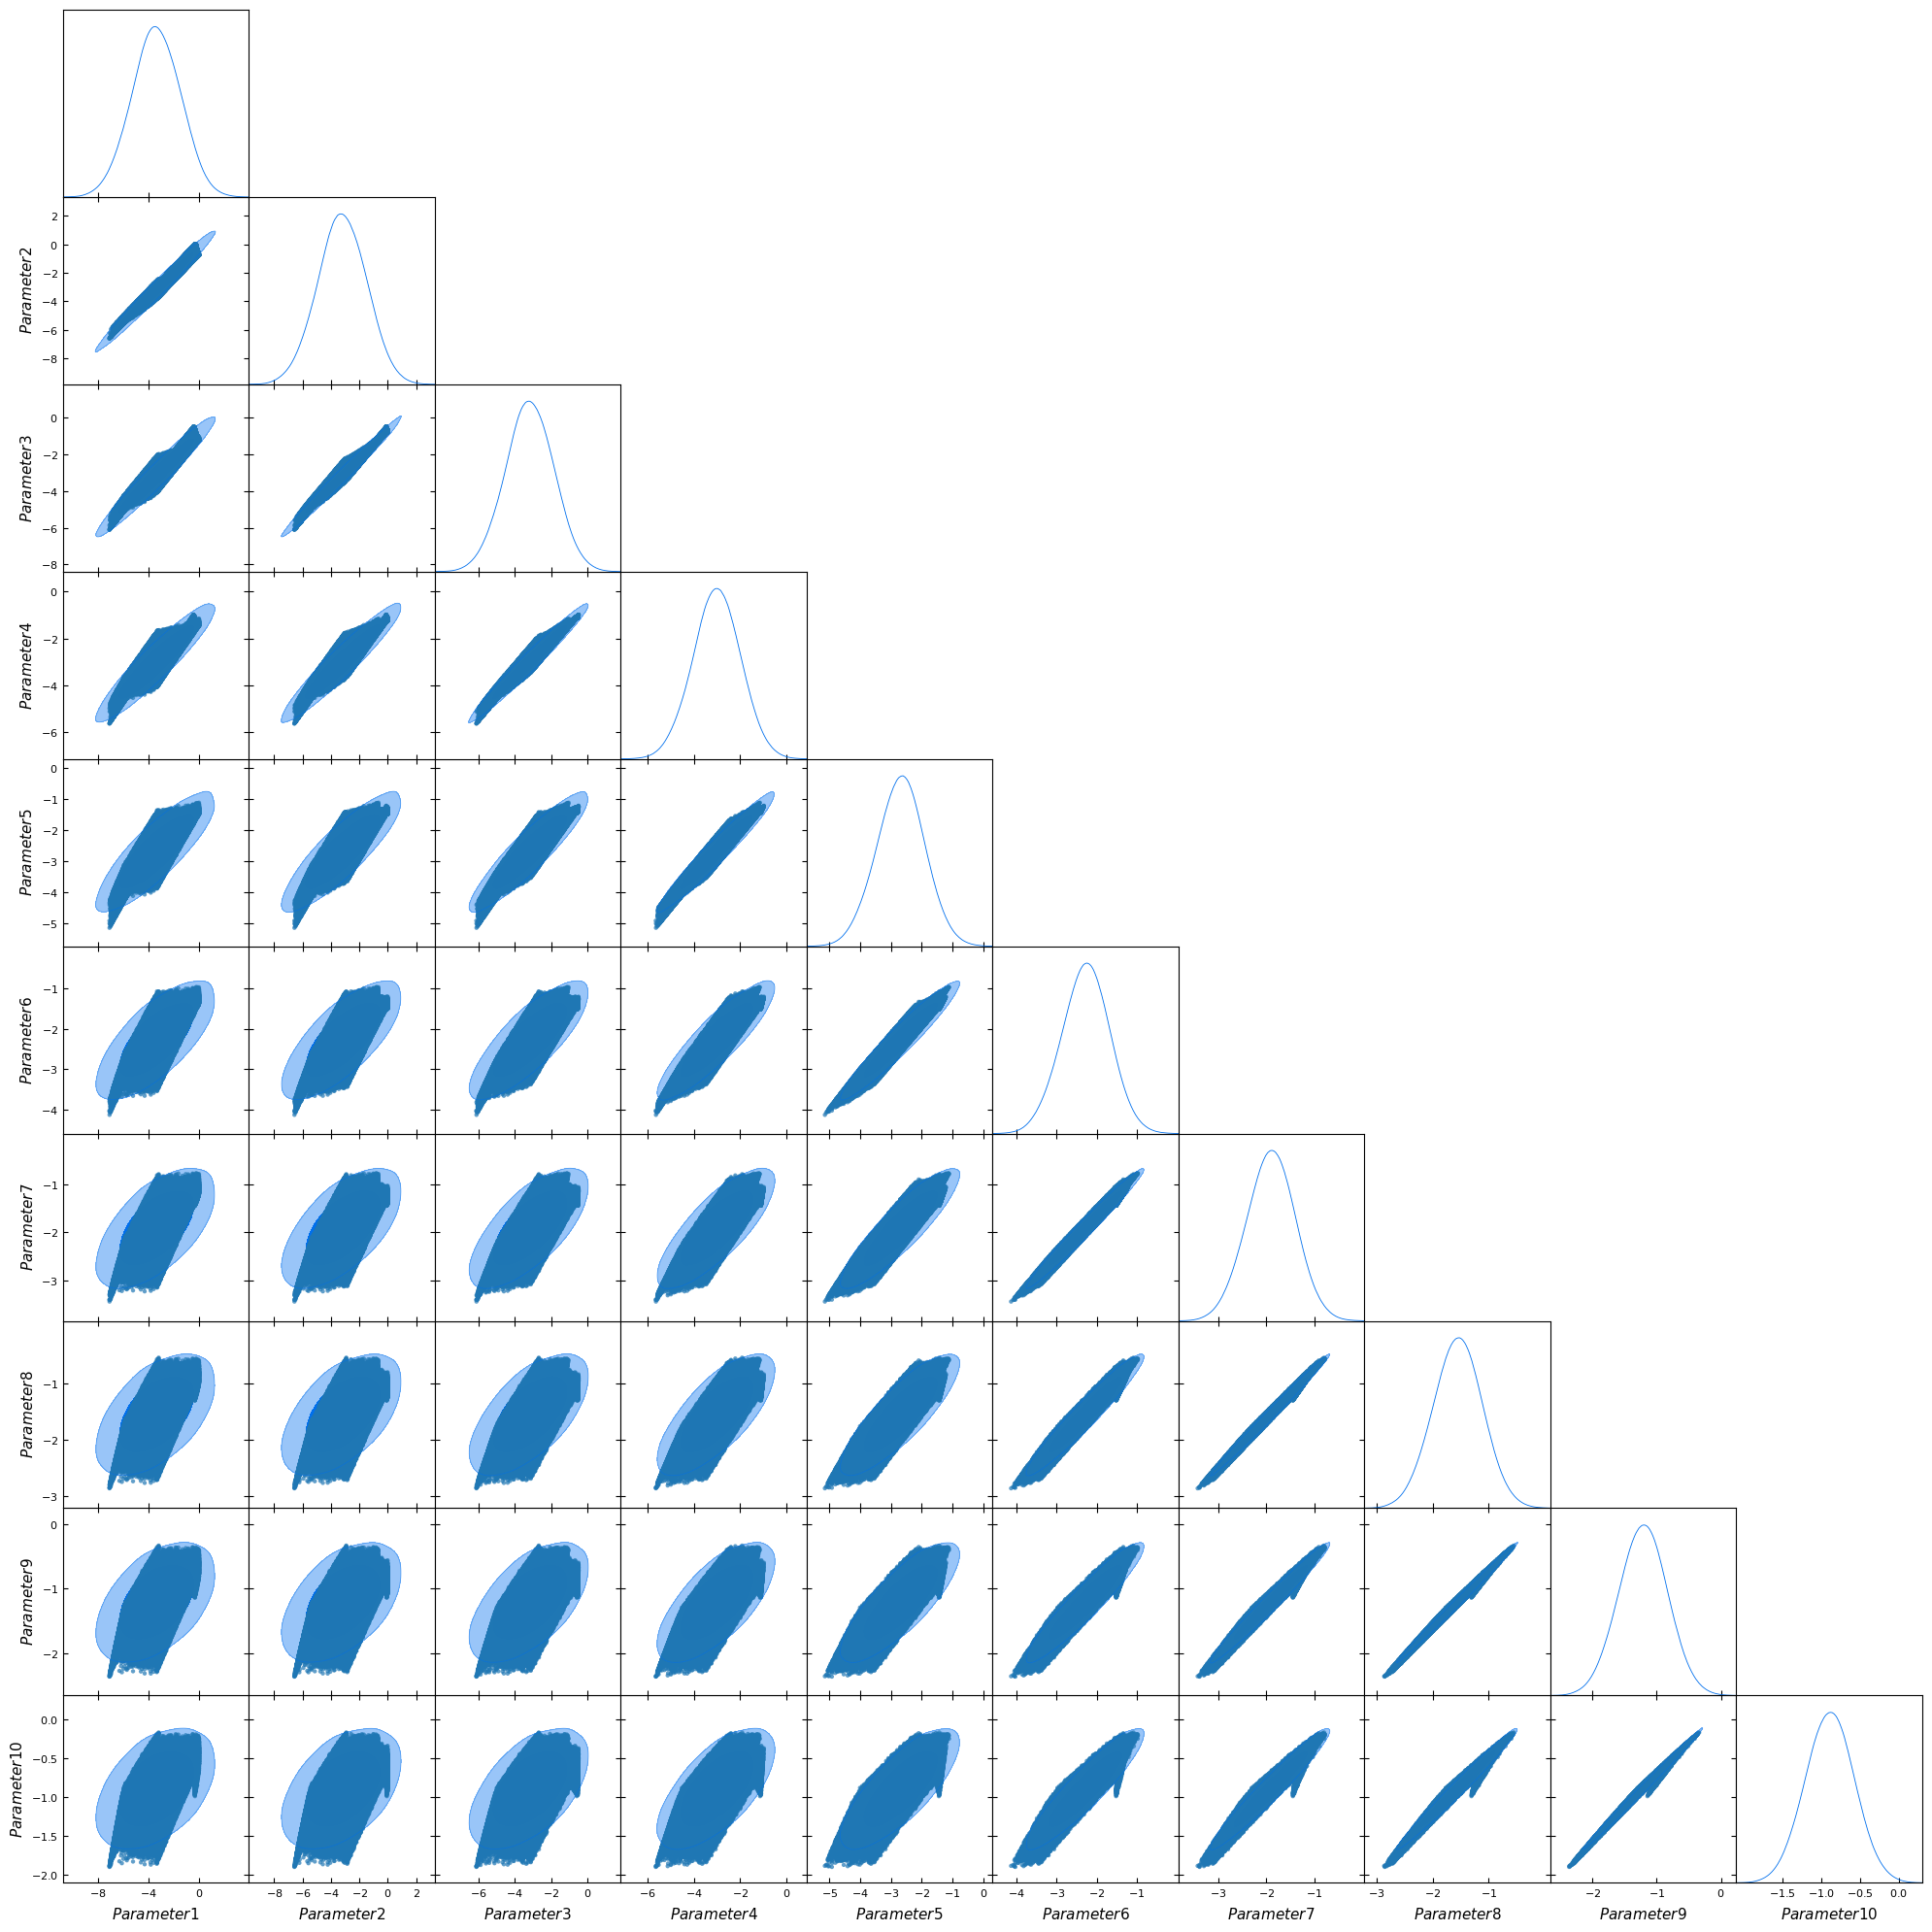

In [6]:
%matplotlib inline
g = plots.get_subplot_plotter()
g.triangle_plot([prior_mc_samples], filled=True)

axes = g.subplots

for i in range(num_params_to_plot):
    for j in range(i):
        ax = axes[i, j]
        if ax is not None:
            x = emu_inputs[:, j]
            y = emu_inputs[:, i]
            scatter = ax.scatter(x, y, s=10, edgecolors='none', alpha=0.7)

fig = g.fig

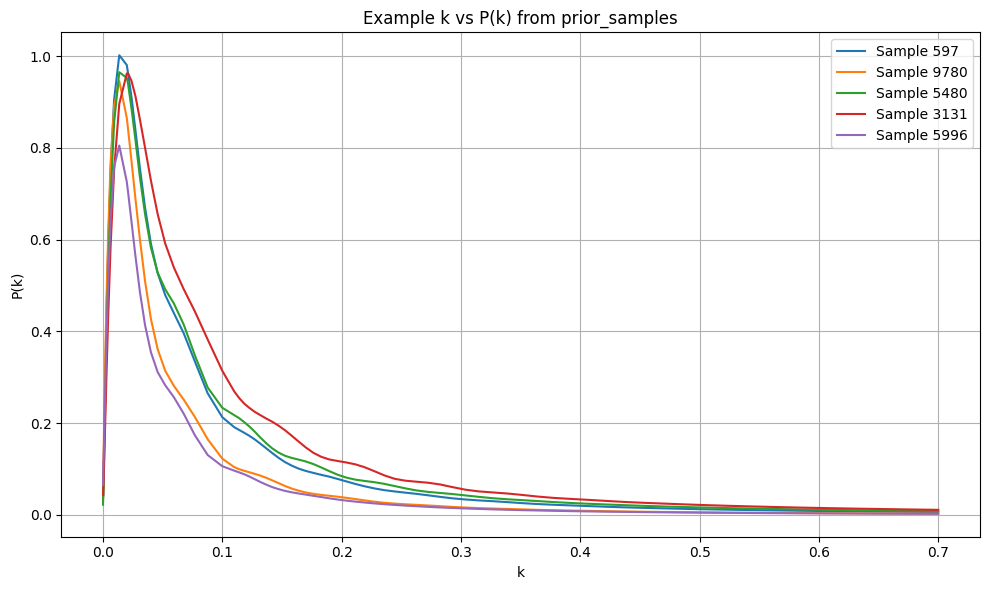

In [7]:
import numpy as np
import matplotlib.pyplot as plt


knots = np.load("/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/knots_data/final_knots_80.npy")# Exponentiate to get P(k) from log P(k)
prior_pk_samples = np.exp(prior_samples[:, :80])  # Shape: N_samples x M_knots

# Plot some example k vs P(k) curves from prior_samples
N_samples=10000
num_plots = 5  # Number of samples to plot
sample_indices = np.random.choice(N_samples, num_plots, replace=False)

plt.figure(figsize=(10, 6))
for idx in sample_indices:
    pk = prior_pk_samples[idx, :]  # Get P(k) for this sample
    plt.plot(knots, pk, label=f'Sample {idx}')

plt.xlabel('k')
plt.ylabel('P(k)')
plt.title('Example k vs P(k) from prior_samples')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('prior_samples_plot.png')  # Save the plot to a file


### lets study the derivatives 

In [8]:
knots = np.load("/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/knots_data/final_knots_80.npy")

In [9]:
emu_inputs = emu_inputs[:, :80]

In [10]:
emu_inputs.shape 

(150000, 80)

In [11]:
sigma_factor=3

In [12]:
def compute_first_derivative(knots, f):
    N, M = f.shape
    df_dx = jnp.zeros_like(f)
    x = knots

    # Compute for i=0 (forward difference)
    df_dx = df_dx.at[:, 0].set((f[:, 1] - f[:, 0]) / (x[1] - x[0]))

    # Compute for i=M-1 (backward difference)
    df_dx = df_dx.at[:, M-1].set((f[:, M-1] - f[:, M-2]) / (x[M-1] - x[M-2]))

    # Compute for interior points i=1 to M-2 (central difference)
    numerator = f[:, 2:] - f[:, :-2]  # N x (M-2)
    denominator = x[2:] - x[:-2]      # (M-2)
    df_dx_interior = numerator / denominator  # Broadcasting over N

    df_dx = df_dx.at[:, 1:M-1].set(df_dx_interior)
    return df_dx

def compute_second_derivative(knots, f):
    N, M = f.shape
    d2f_dx2 = jnp.zeros_like(f)
    x = knots

    # Compute for i=0 (forward difference)
    h0 = x[1] - x[0]
    h1 = x[2] - x[1]
    f0, f1, f2 = f[:, 0], f[:, 1], f[:, 2]
    d2f_dx2_0 = 2 * ((f2 - f1) / h1 - (f1 - f0) / h0) / (h0 + h1)
    d2f_dx2 = d2f_dx2.at[:, 0].set(d2f_dx2_0)

    # Compute for i=M-1 (backward difference)
    h0 = x[M-1] - x[M-2]
    h1 = x[M-2] - x[M-3]
    f0, f1, f2 = f[:, M-1], f[:, M-2], f[:, M-3]
    d2f_dx2_M1 = 2 * ((f0 - f1) / h0 - (f1 - f2) / h1) / (h0 + h1)
    d2f_dx2 = d2f_dx2.at[:, M-1].set(d2f_dx2_M1)

    # Compute for interior points i=1 to M-2
    h_prev = x[1:-1] - x[:-2]
    h_next = x[2:] - x[1:-1]
    f_prev = f[:, :-2]
    f_curr = f[:, 1:-1]
    f_next = f[:, 2:]

    d2f_dx2_interior = 2 * ((f_next - f_curr) / h_next - (f_curr - f_prev) / h_prev) / (h_prev + h_next)
    d2f_dx2 = d2f_dx2.at[:, 1:M-1].set(d2f_dx2_interior)
    return d2f_dx2

# Convert to JAX arrays
emu_inputs_jax = jnp.array(emu_inputs)
knots_jax = jnp.array(knots)

# Compute first and second derivatives using JAX
df_dx = compute_first_derivative(knots_jax, emu_inputs_jax)
d2f_dx2 = compute_second_derivative(knots_jax, emu_inputs_jax)

new_sample_size (100, 80)


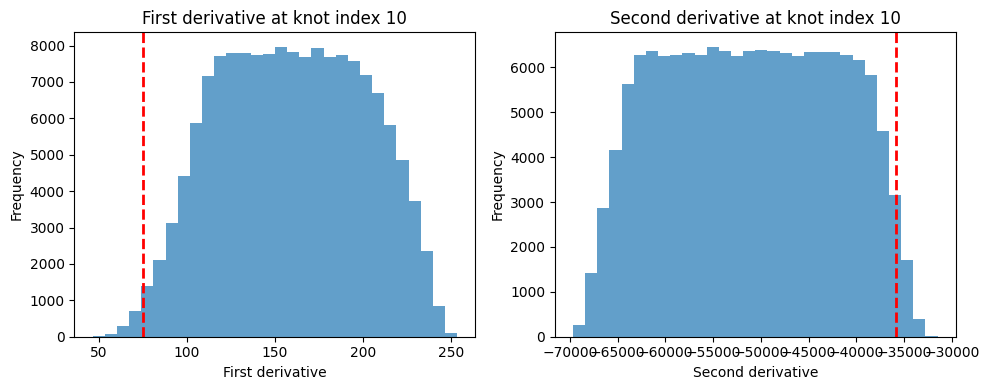

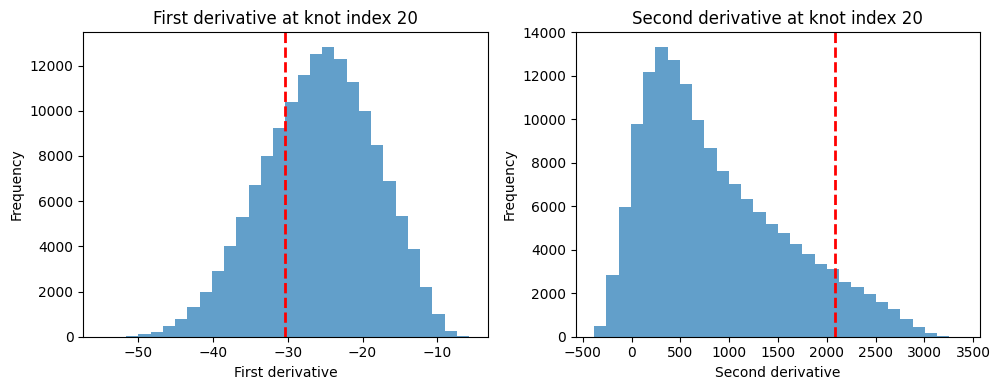

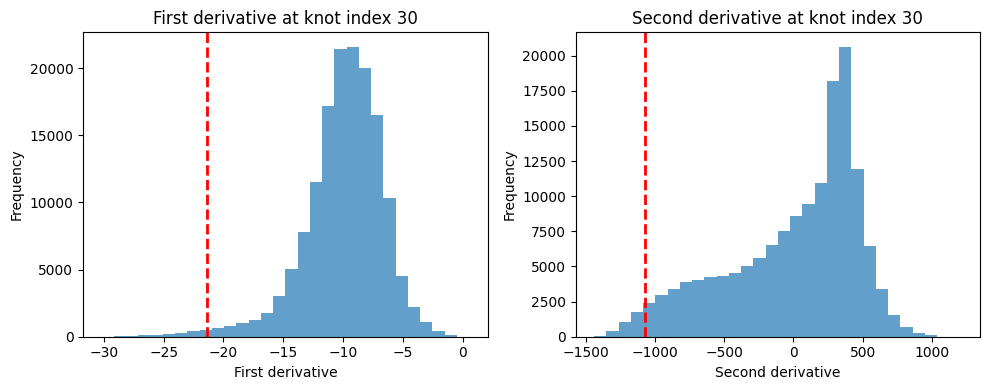

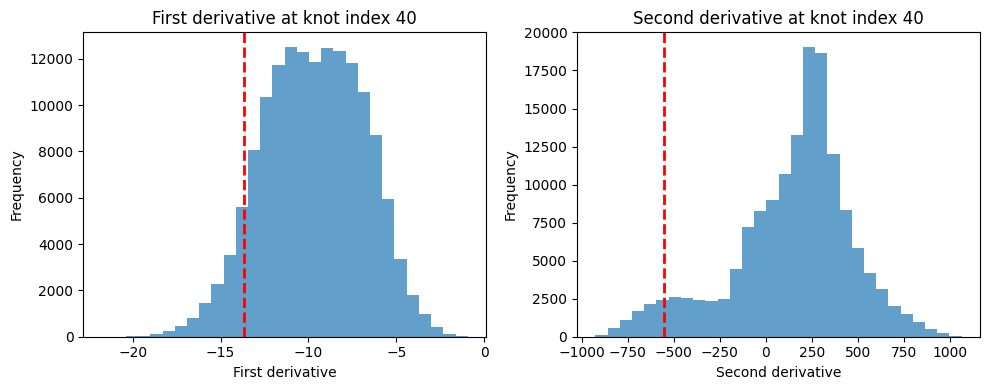

In [13]:
# New sample
# new_sample_log_pk_jax = model.sample(subkey, 4, sigma_factor=1.)[:, :80]
# rng_key = jax.random.PRNGKey(int(5))
# new_sample_log_pk_jax = generate_new_samples(empirical_cdfs, mean_gaussian, cov_gaussian, num_samps, rng_key)[:, :80]
# print("new_sample_size", new_sample_log_pk_jax.shape)
num_samps = 100
rng_key = jax.random.PRNGKey(int(5))
new_sample_log_pk_jax = generate_new_samples(rng_key, num_samps, sigma_factor=sigma_factor)[:, :80]
print("new_sample_size", new_sample_log_pk_jax.shape)

# Compute derivatives for the new sample
new_df_dx = compute_first_derivative(knots_jax, new_sample_log_pk_jax)
new_d2f_dx2 = compute_second_derivative(knots_jax, new_sample_log_pk_jax)

# Plotting distributions and overlaying new sample
selected_indices = [10, 20, 30, 40]  # Indices of knot points to plot

for idx in selected_indices:
    plt.figure(figsize=(10, 4))

    # First derivative
    plt.subplot(1, 2, 1)
    plt.hist(df_dx[:, idx], bins=30, alpha=0.7)
    plt.axvline(new_df_dx[0, idx], color='red', linestyle='dashed', linewidth=2)
    plt.title(f'First derivative at knot index {idx}')
    plt.xlabel('First derivative')
    plt.ylabel('Frequency')

    # Second derivative
    plt.subplot(1, 2, 2)
    plt.hist(d2f_dx2[:, idx], bins=30, alpha=0.7)
    plt.axvline(new_d2f_dx2[0, idx], color='red', linestyle='dashed', linewidth=2)
    plt.title(f'Second derivative at knot index {idx}')
    plt.xlabel('Second derivative')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

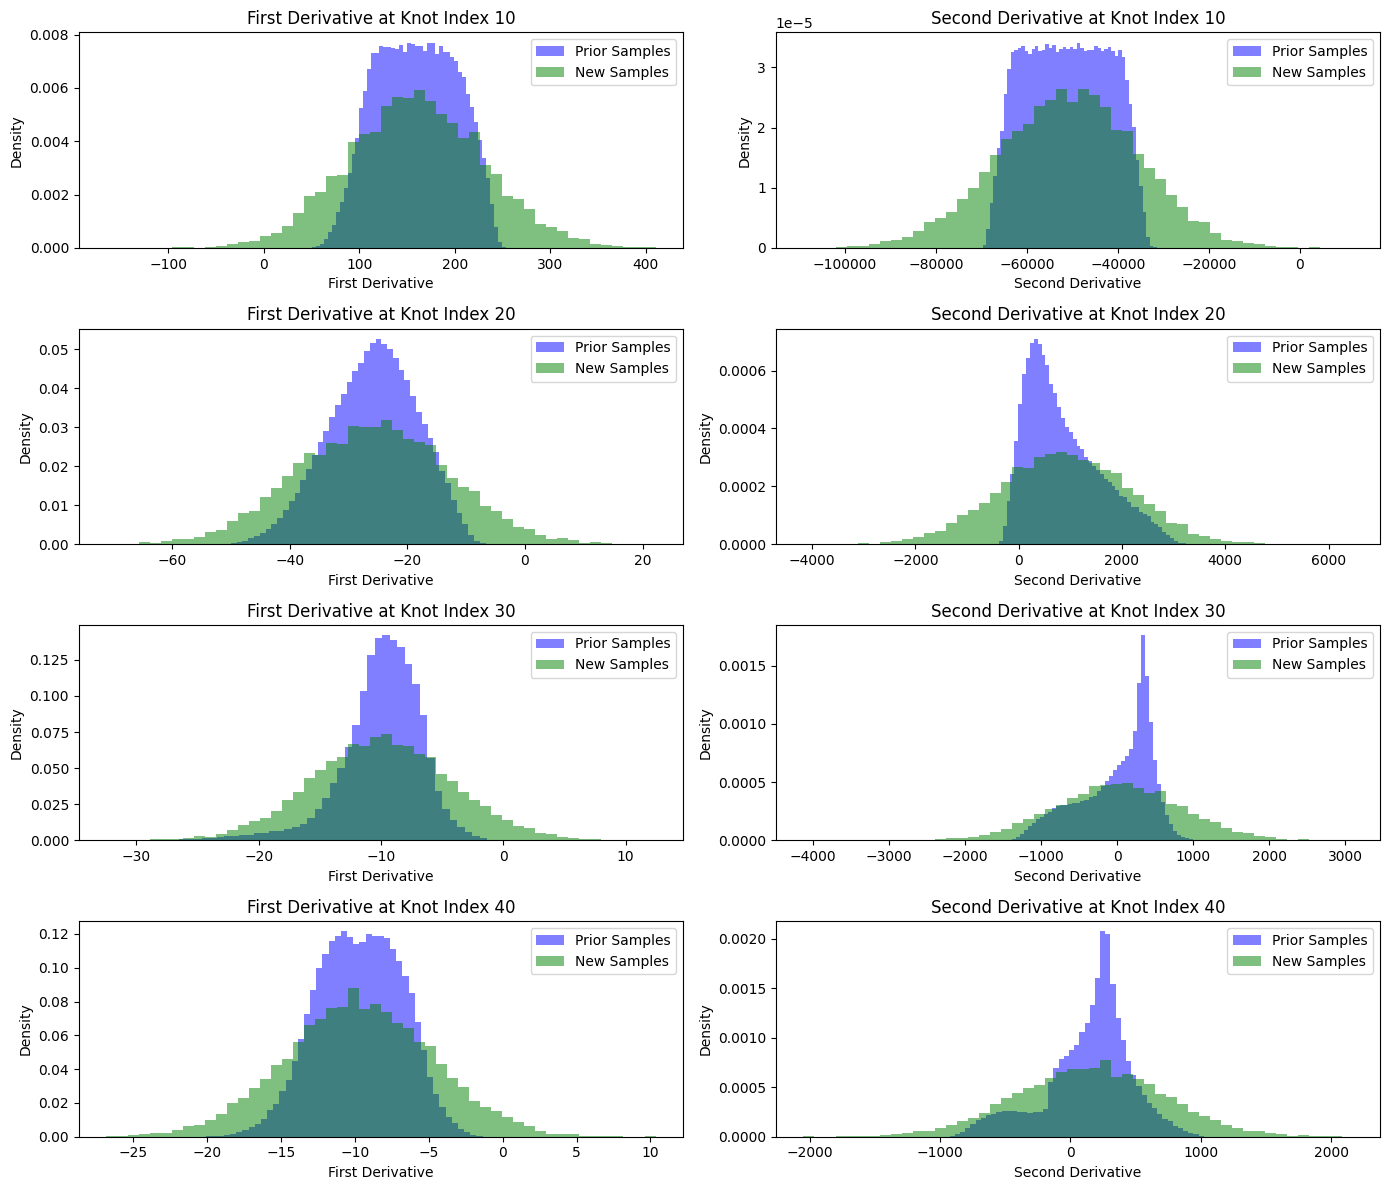

In [14]:

# Number of new samples to generate
num_new_samples = 10000

# Generate new samples using the model
# new_sample_log_pk_jax = model.sample(subkey, num_new_samples, sigma_factor=1.)[:, :80]
# print("new_sample_size", new_sample_log_pk_jax.shape)
# new_sample_log_pk_jax = generate_new_samples(empirical_cdfs, mean_gaussian, cov_gaussian, num_new_samples, rng_key)[:, :80]

new_sample_log_pk_jax = generate_new_samples(rng_key, num_new_samples,sigma_factor=sigma_factor)[:, :80]

# Compute derivatives for the new samples
new_df_dx = compute_first_derivative(knots_jax, new_sample_log_pk_jax)
new_d2f_dx2 = compute_second_derivative(knots_jax, new_sample_log_pk_jax)

# Plotting distributions of prior samples and new samples
selected_indices = [10, 20, 30, 40]  # Indices of knot points to plot

# Create a figure with appropriate size
plt.figure(figsize=(14, 12))

# Total number of subplots: 2 plots (first and second derivative) per selected index
num_subplots = len(selected_indices) * 2

# Loop over selected indices and create subplots
for i, idx in enumerate(selected_indices):
    # First derivative subplot
    plt.subplot(len(selected_indices), 2, 2 * i + 1)
    bins = 50  # Number of bins for the histogram
    plt.hist(df_dx[:, idx], bins=bins, alpha=0.5, label='Prior Samples', color='blue', density=True)
    plt.hist(new_df_dx[:, idx], bins=bins, alpha=0.5, label='New Samples', color='green', density=True)
    plt.title(f'First Derivative at Knot Index {idx}')
    plt.xlabel('First Derivative')
    plt.ylabel('Density')
    plt.legend()

    # Second derivative subplot
    plt.subplot(len(selected_indices), 2, 2 * i + 2)
    plt.hist(d2f_dx2[:, idx], bins=bins, alpha=0.5, label='Prior Samples', color='blue', density=True)
    plt.hist(new_d2f_dx2[:, idx], bins=bins, alpha=0.5, label='New Samples', color='green', density=True)
    plt.title(f'Second Derivative at Knot Index {idx}')
    plt.xlabel('Second Derivative')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.savefig('all_derivative_distributions.png')  # Save the entire figure as one image
plt.show()

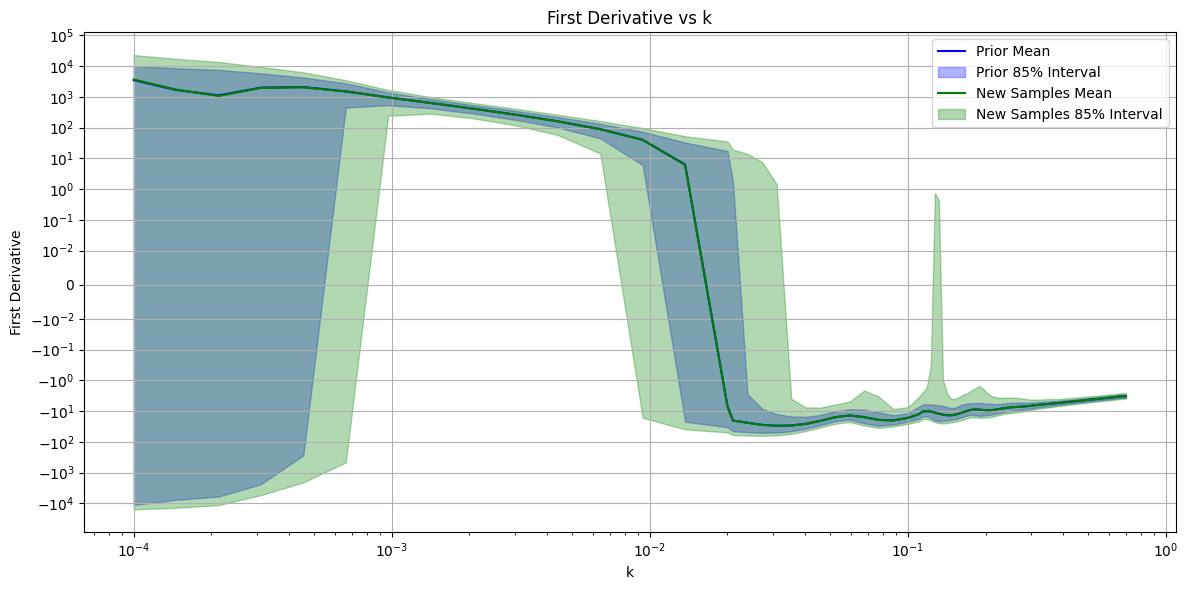

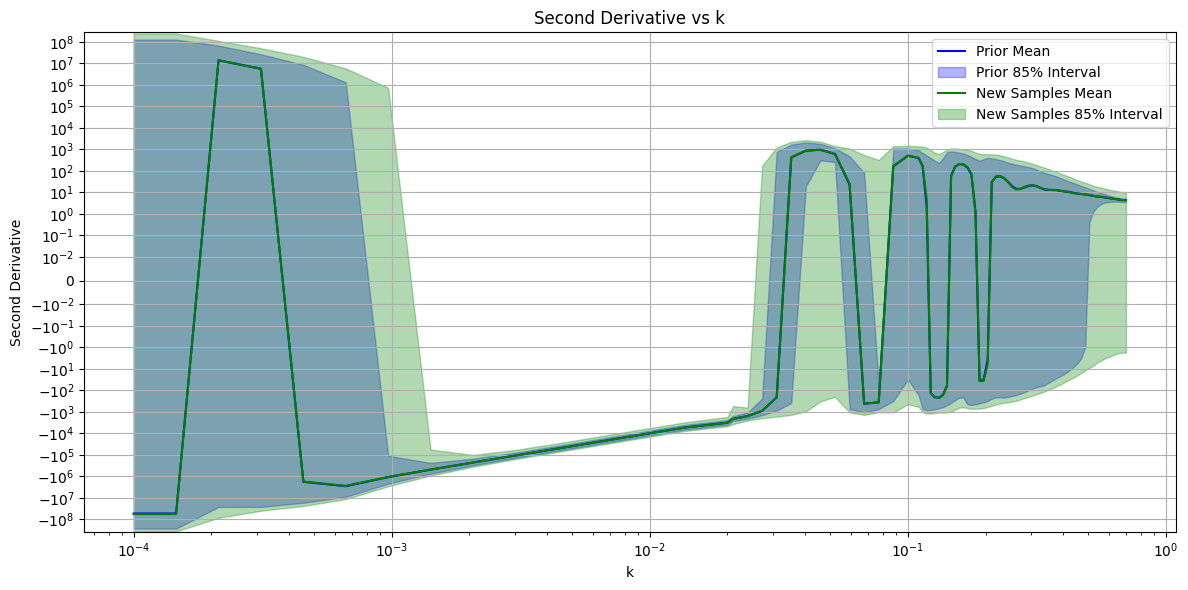

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure that knots is a NumPy array
knots_np = np.array(knots_jax)

# Convert derivative arrays to NumPy arrays if they are JAX arrays
df_dx_np = np.array(df_dx)
d2f_dx2_np = np.array(d2f_dx2)
new_df_dx_np = np.array(new_df_dx)
new_d2f_dx2_np = np.array(new_d2f_dx2)

# Compute statistics for prior samples (emu_inputs)
mean_df_dx_prior = np.mean(df_dx_np, axis=0)
lower_df_dx_prior = np.percentile(df_dx_np, 7.5, axis=0)
upper_df_dx_prior = np.percentile(df_dx_np, 92.5, axis=0)

mean_d2f_dx2_prior = np.mean(d2f_dx2_np, axis=0)
lower_d2f_dx2_prior = np.percentile(d2f_dx2_np, 7.5, axis=0)
upper_d2f_dx2_prior = np.percentile(d2f_dx2_np, 92.5, axis=0)

# Compute statistics for new samples
mean_df_dx_new = np.mean(new_df_dx_np, axis=0)
lower_df_dx_new = np.percentile(new_df_dx_np, 7.5, axis=0)
upper_df_dx_new = np.percentile(new_df_dx_np, 92.5, axis=0)

mean_d2f_dx2_new = np.mean(new_d2f_dx2_np, axis=0)
lower_d2f_dx2_new = np.percentile(new_d2f_dx2_np, 7.5, axis=0)
upper_d2f_dx2_new = np.percentile(new_d2f_dx2_np, 92.5, axis=0)

# Plotting first derivatives
plt.figure(figsize=(12, 6))

# Prior samples
plt.plot(knots_np, mean_df_dx_prior, label='Prior Mean', color='blue')
plt.fill_between(knots_np, lower_df_dx_prior, upper_df_dx_prior, color='blue', alpha=0.3, label='Prior 85% Interval')

# New samples
plt.plot(knots_np, mean_df_dx_new, label='New Samples Mean', color='green')
plt.fill_between(knots_np, lower_df_dx_new, upper_df_dx_new, color='green', alpha=0.3, label='New Samples 85% Interval')

linthresh_value = 0.01  # Try different values like 0.01, 0.1, 1

plt.yscale('symlog', linthresh=linthresh_value)
plt.xlabel('k')
plt.xscale("log")
plt.ylabel('First Derivative')
plt.title('First Derivative vs k')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('first_derivative_vs_k.png')  # Save the plot
plt.show()

# Plotting second derivatives
plt.figure(figsize=(12, 6))

# Prior samples
plt.plot(knots_np, mean_d2f_dx2_prior, label='Prior Mean', color='blue')
plt.fill_between(knots_np, lower_d2f_dx2_prior, upper_d2f_dx2_prior, color='blue', alpha=0.3, label='Prior 85% Interval')

# New samples
plt.plot(knots_np, mean_d2f_dx2_new, label='New Samples Mean', color='green')
plt.fill_between(knots_np, lower_d2f_dx2_new, upper_d2f_dx2_new, color='green', alpha=0.3, label='New Samples 85% Interval')

plt.xlabel('k')
plt.xscale("log")

linthresh_value = 0.01  # Try different values like 0.01, 0.1, 1

plt.yscale('symlog', linthresh=linthresh_value)
plt.ylabel('Second Derivative')
plt.title('Second Derivative vs k')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('second_derivative_vs_k.png')  # Save the plot
plt.show()
